{'red': [], 'blue': [], 'orange': [], 'springGreen': []}
{'red': [], 'blue': [], 'orange': [], 'springGreen': array([[1629.91732121, 1226.44547334]])}
{'red': array([[1766.24053601, 2315.26298157]]), 'blue': [], 'orange': [], 'springGreen': []}
{'red': [], 'blue': array([[2254.46540599, 2503.00681126]]), 'orange': [], 'springGreen': []}


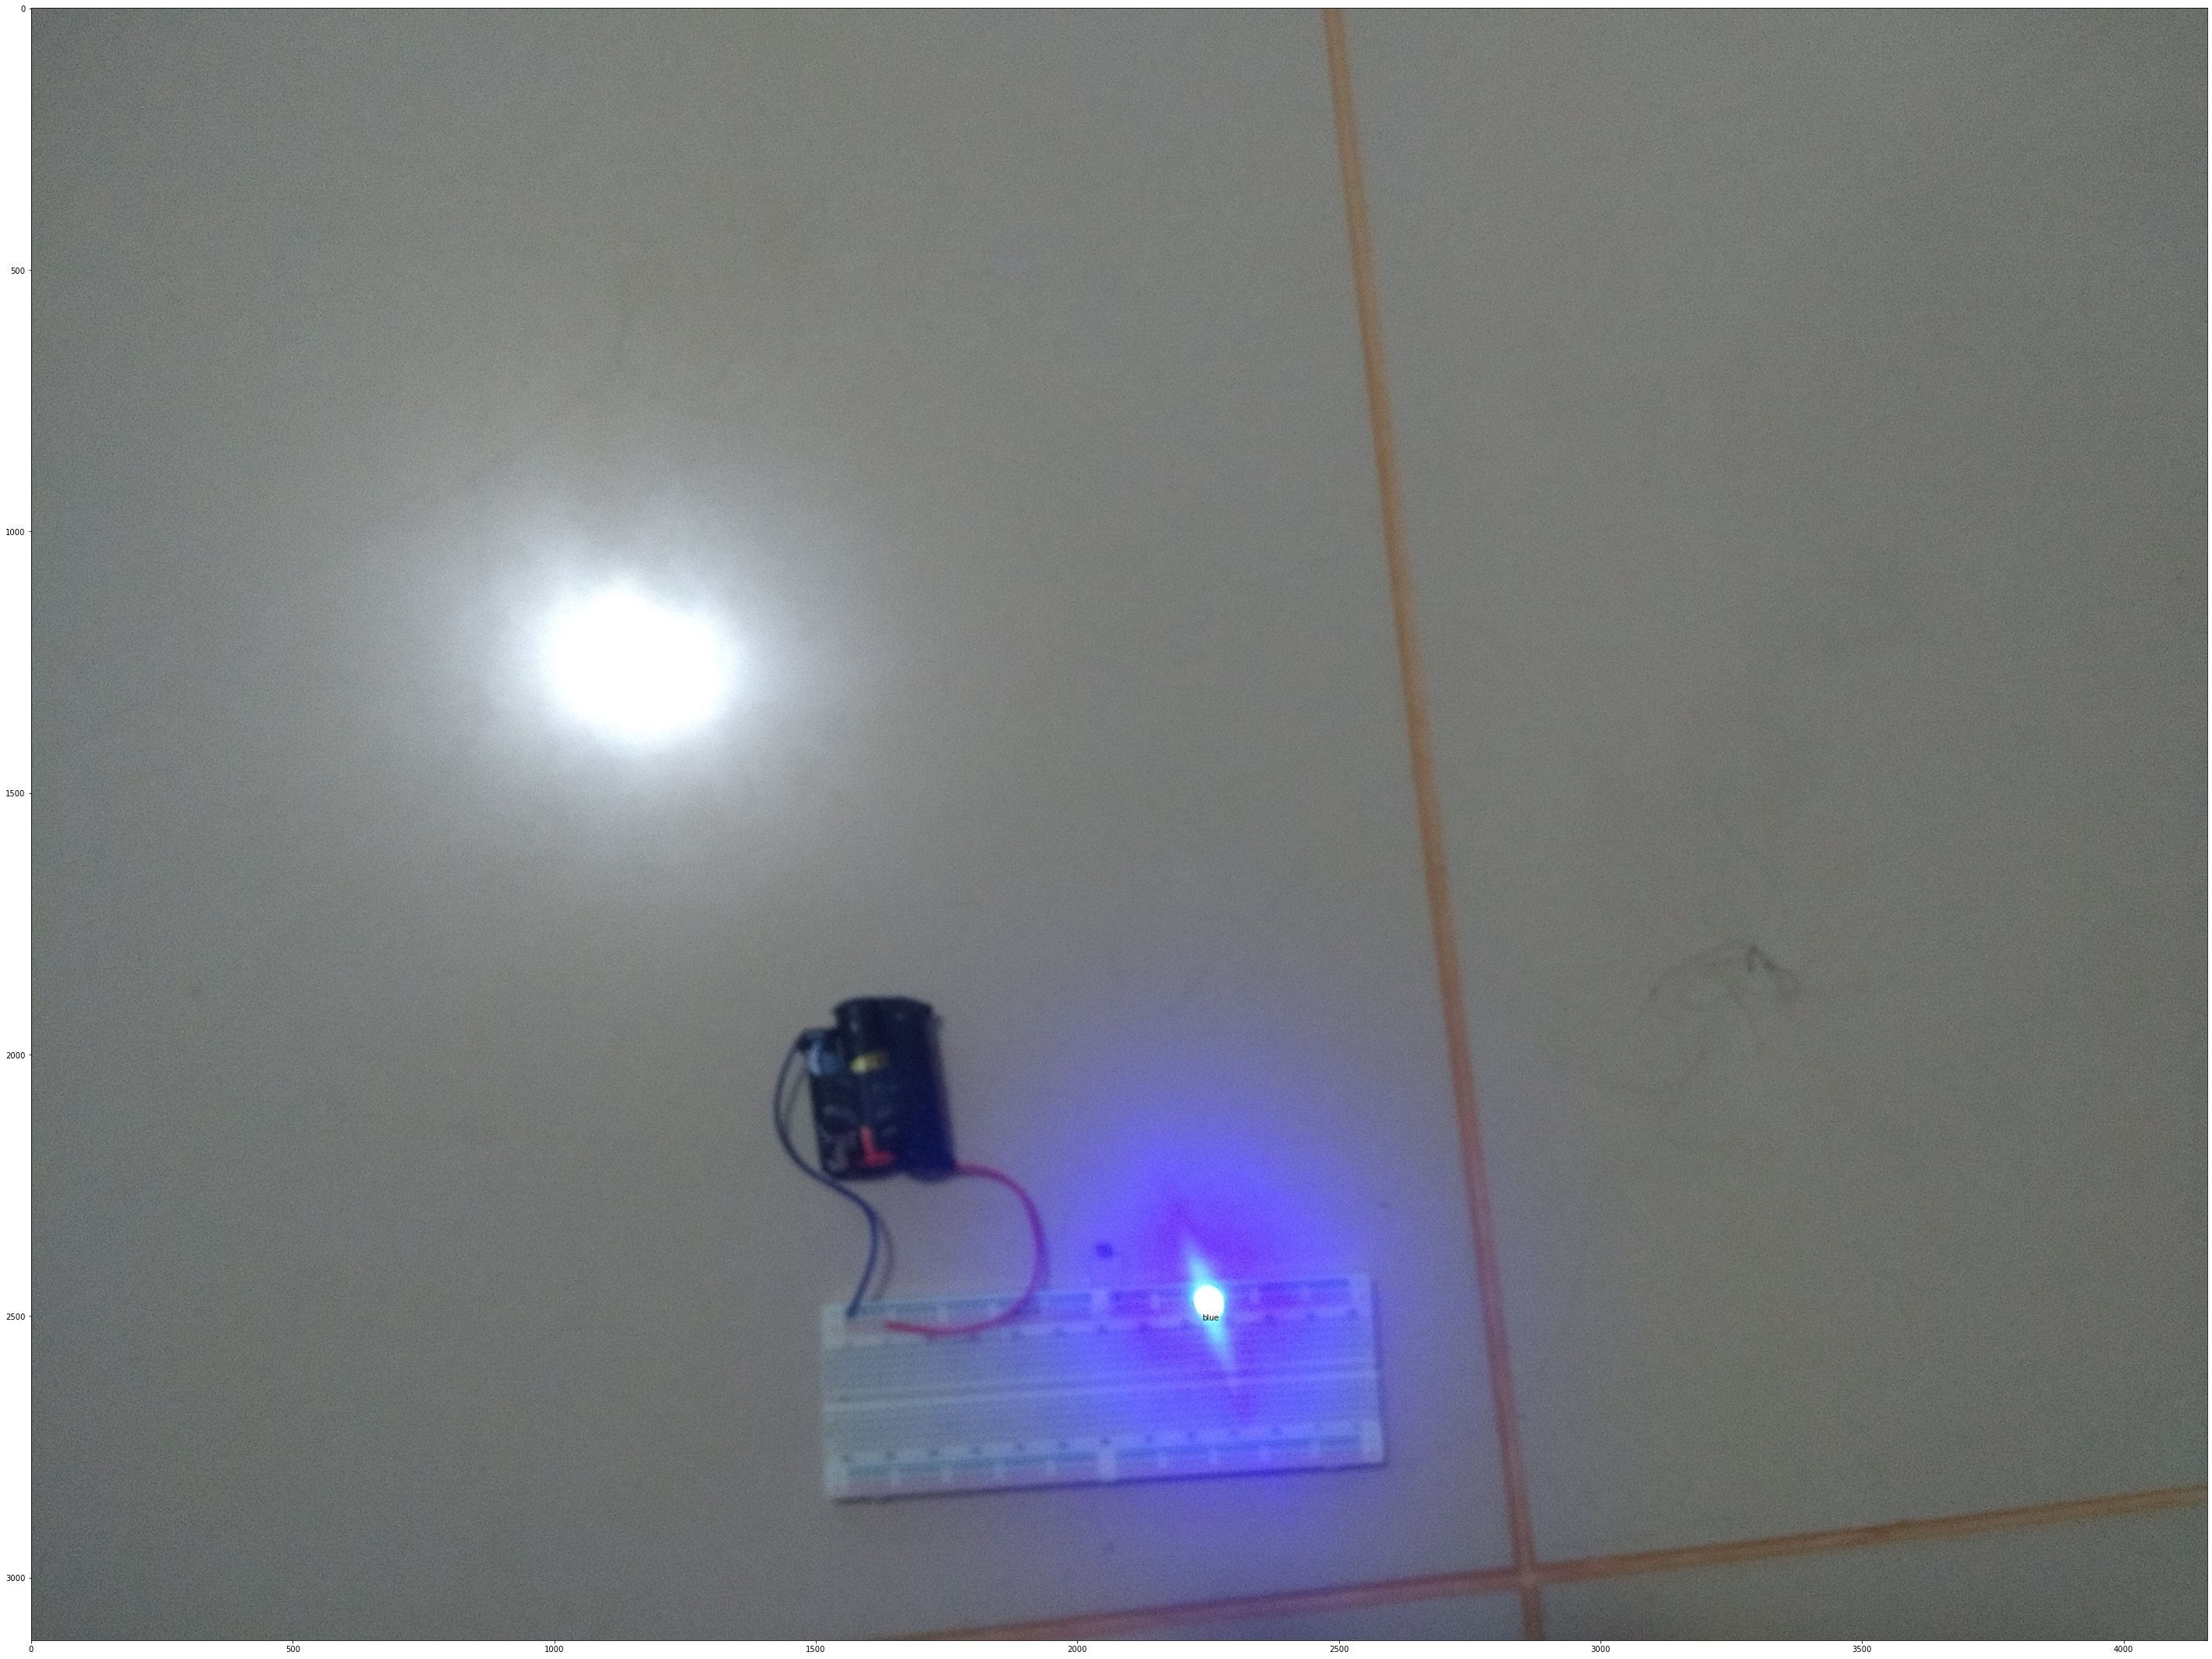

In [8]:
import robot_color_tracking as track
import numpy as np

#tracker = track.GeometricTrack(areaBounds = (200, 20000),binaryThreshold= 70, segmentMethod='multipleColors', color=['red', 'yellow', 'blue', 'green'] , debug=True)
#tracker = track.HoughColorTrack(binaryThreshold = 80, hueTolerance = 10, debug=True, nbr_colors=4)
#tracker = track.ColorTrack(binaryThreshold = 80, hueTolerance = 70,kernel = np.ones((10,10)), nbr_colors=4)
#track.GeometricTrack(areaBounds = (200, 20000),binaryThreshold= 70, segmentMethod='multipleColors', color=['red', 'yellow', 'blue', 'green'] , debug=True)

#tracker = track.HoughColorTrack(binaryThreshold = 80, hueTolerance = 10, debug=True,param1=20, param2=10, minRadius=0,maxRadius=0, nbr_colors=4)
tracker = track.ColorTrack(binaryThreshold= 60, hueTolerance = 10,kernel = np.ones((10,10)),colors=['red', 'blue', 'orange', 'springGreen'], debug=True)
tracker.track('../img/leds/place_2/yellow/IMG_20201110_211757830.jpg')
print(tracker.getPoses())
tracker.track('../img/leds/place_2/green/IMG_20201110_211900812.jpg')
print(tracker.getPoses())
tracker.track('../img/leds/place_2/red/IMG_20201110_211458883.jpg')
print(tracker.getPoses())
tracker.track('../img/leds/place_2/blue/IMG_20201110_211645733_BURST000_COVER_TOP.jpg')
print(tracker.getPoses())

tracker.printRobotLocation()

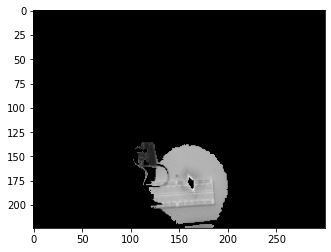

In [9]:
import matplotlib.pyplot as plt

plt.gray()
plt.imshow(tracker.segmentedImages['blue'])

In [32]:
# statisticas

import robot_color_tracking as track
import numpy as np
import json

# Compara o erro entre o resultado esperado e o erro encontrado
#methods = [ 'shapes_one_color','shapes','shapes_colors','colors_naive','colors'] 
methods = ['leds']
timeOfTrack = {}
for m in methods:
    if m == 'shapes':
        tracker = track.GeometricTrack(binaryThreshold= 140, segmentMethod='simple')
    elif m == 'colors_naive':
        tracker = track.ColorTrack(binaryThreshold = 80, hueTolerance = 10,kernel = np.ones((10,10)), nbr_colors=4)
    elif m == 'leds':
        tracker = track.LedTrack(binaryThreshold= 60, hueTolerance = 10,kernel = np.ones((10,10)),colors=['red', 'blue', 'orange', 'springGreen'])
    elif m == 'shapes_colors':
        tracker = track.GeometricTrack(areaBounds = (200, 20000),binaryThreshold= 70, segmentMethod='multipleColors', color=['red', 'yellow', 'blue', 'green'])
    elif m == 'colors':
        tracker = track.HoughColorTrack(binaryThreshold = 80, hueTolerance = 10,param1=20, param2=10, minRadius=0,maxRadius=0, nbr_colors=4)
    elif m == 'shapes_one_color':
        tracker = track.GeometricTrack(areaBounds = (200, 20000),binaryThreshold= 70, segmentMethod='oneColor',color='red')


    data = {}
    error = {"place_1": {},"place_2": {},"place_3": {},"place_4": {},}
    e = 0
    with open('../algorithm_performance_data/real_positions/'+m+'_positions.json', 'r') as f:
        data = json.load(f)
    imgNum = 0
    place = 0
    counterProgress = 0
    for d in sorted(data):
        print('\r'+m+': '+str(format(100*counterProgress/len(data),'.2f'))+'%', end='')
        counterProgress+=1
        color = data[d]['color']
        place = data[d]['place']
        tracker.track('../img/'+m+'/'+place+'/'+color+'/'+d)
        trackedPoses = tracker.getPoses()
        realPoses = data[d]['position']
        for pos in realPoses:
            if( len(pos) == 0):
                if color in trackedPoses:
                    for cont in range(len(trackedPoses[color])):
                        error[place][e] = 'false positive'
                        e+=1
            elif color in trackedPoses:
                if len(trackedPoses[color]) != 0:
                    pos = np.array(pos)
                    posT = np.array(trackedPoses[color])
                    if posT.shape[0]==1:
                        if posT.shape[1] == 2:
                            error[place][e] = (posT - pos).tolist()
                        else:
                            error[place][e] = 'false negative'
                    else:
                        dif = posT - pos
                        argminError= (dif**2).sum(axis=1).argmin()
                        error[place][e] = dif[argminError].tolist()
                        for cont in range(posT.shape[0]-1):
                            e+=1
                            error[place][e] = "false positive"
                else:
                    error[place][e] = 'false negative'  
                e+=1
            else:
                #print(d)
                error[place][e] = 'false negative'
                e+=1
        imgNum+=1

    print('\r'+m+': '+format(100*counterProgress/len(data),'.2f')+'%')
    timeOfTrack[m] = tracker.time
    for i in sorted(error):
        with open('../algorithm_performance_data/error/error_'+m+'_'+str(i)+'.json', 'w') as f:
            json.dump(error[i], f)
    with open('../algorithm_performance_data/time/time_'+m+'.json', 'w') as f:
            json.dump(timeOfTrack[m], f)

leds: 100.00%


In [33]:
import json
import numpy as np

# Cálculo de medidas estatísticas

methods = [ 'leds']
statistics = {}
places = ["place_1","place_2","place_3","place_4"]
for m in methods:

    distanceMean = []
    distanceDeviation = []
    falseNegative = []
    falsePositive = []
    detected = []
    

    
    for cont in places:    
        with open('../algorithm_performance_data/error/error_'+ m +'_'+str(cont)+'.json', 'r') as f:
            data = json.load(f)

        #for d in range(len(data)):
        #    data[d] = data[str(d)]
        #    del(data[str(d)])
        #print(data)
        errorNegative=0
        errorPositive=0
        errorDist = np.array([0,0])
        euclDist = []
        
        i=0
        for d in data:
            if data[d]=='false negative':
                errorNegative+=1
            elif data[d] == 'false positive':
                errorPositive += 1
            else:
                errorDist = errorDist + np.array(data[d])
                euclDist.append(np.sqrt((np.array(data[d])**2).sum()))
                i+=1
        #print(i)
        if i != 0:
            errorDist = np.sqrt(((errorDist/i)**2).sum())
        else:
            errorDist = -10
        errorNegative /= len(data)
        errorPositive /= len(data)
        detect = i/len(data)
        if len(euclDist)==0:
                distanceDeviation.append(-10)
        else:
            distanceDeviation.append(np.std(np.array(euclDist)))
        distanceMean.append(errorDist)
        falseNegative.append(errorNegative)
        falsePositive.append(errorPositive)
        detected.append(detect)
    with open('../algorithm_performance_data/time/time_'+ m +'.json', 'r') as f:
            timeOfProcessing = np.array(json.load(f))
    
    statistics[m]= {'distanceDeviation': distanceDeviation,'distanceMean':distanceMean,
                    'falseNegative':falseNegative, 'falsePositive':falsePositive, 'detected':detected,
                    'time': timeOfProcessing}

In [7]:
statistics

{'leds': {'distanceDeviation': [37.94048924223431,
   124.5806572761606,
   359.5985828384229,
   14.623648840432223],
  'distanceMean': [39.01443617579558,
   29.523796111053528,
   90.14358173972623,
   73.02888748007847],
  'falseNegative': [0.6363636363636364,
   0.5151515151515151,
   0.3055555555555556,
   0.75],
  'falsePositive': [0.0, 0.0, 0.1111111111111111, 0.0],
  'detected': [0.36363636363636365,
   0.48484848484848486,
   0.5833333333333334,
   0.25],
  'time': array([0.30046844, 0.34900713, 0.26323724, 0.26529789, 0.26330924,
         0.26322794, 0.26413727, 0.26625109, 0.26310134, 0.26202726,
         0.2643826 , 0.26286888, 0.26623297, 0.26281476, 0.26315212,
         0.26426029, 0.26332712, 0.26330066, 0.26323128, 0.26593947,
         0.26724839, 0.26023221, 0.26321101, 0.26205969, 0.34833598,
         0.35191417, 0.36435962, 0.34763193, 0.26399064, 0.26229644,
         0.26559258, 0.27010441, 0.26294637, 0.35071397, 0.34764457,
         0.35067368, 0.2628181 , 0.2848

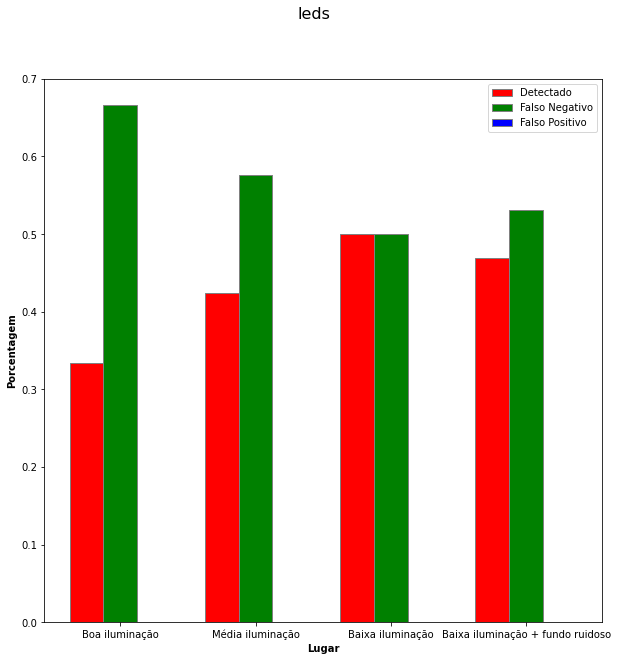

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 

# Gráfico com índices de detecção

for m in statistics:
    plt.figure(figsize=(10,10))
    plt.bar(range(1, 16, 4), statistics[m]['detected'], color ='r', width =1, 
            edgecolor ='grey', label ='Detectado') 
    plt.bar(range(2, 16, 4), statistics[m]['falseNegative'], color ='g', width = 1, 
            edgecolor ='grey', label ='Falso Negativo') 
    plt.bar(range(3, 16, 4), statistics[m]['falsePositive'], color ='b', width = 1, 
            edgecolor ='grey', label ='Falso Positivo') 

    # Adding Xticks  
    plt.xlabel('Lugar', fontweight ='bold') 
    plt.ylabel('Porcentagem', fontweight ='bold') 
    plt.xticks([2, 6, 10 , 14],
               ['Boa iluminação', 'Média iluminação', 'Baixa iluminação', 'Baixa iluminação + fundo ruidoso']) 
    plt.suptitle(m, fontsize=16)
    plt.legend()
    plt.savefig('../algorithm_performance_data/graphs/'+m+'_detections.png')
    plt.show()

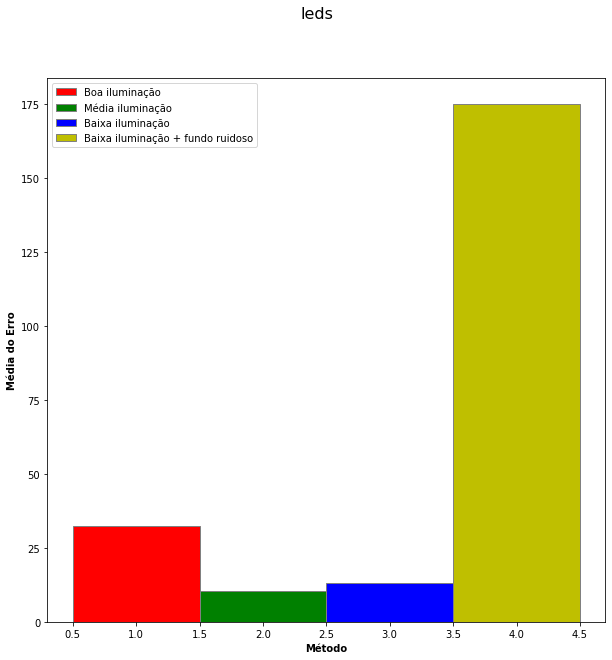

In [35]:
# Gráfico com distância média do local esperado

color = ['r', 'g', 'b', 'y']
label = ['Boa iluminação', 'Média iluminação', 'Baixa iluminação', 'Baixa iluminação + fundo ruidoso']

plt.figure(figsize=(10,10))
for i in range(4):
    plt.bar(i+1,[statistics['leds']['distanceMean'][i]],
                             color =color[i], width =1, edgecolor ='grey', label =label[i])

# Adding Xticks
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Média do Erro', fontweight ='bold') 
plt.suptitle(m, fontsize=16)   
plt.legend()
plt.savefig('../algorithm_performance_data/graphs/'+m+'_mean_error.png')
plt.show()

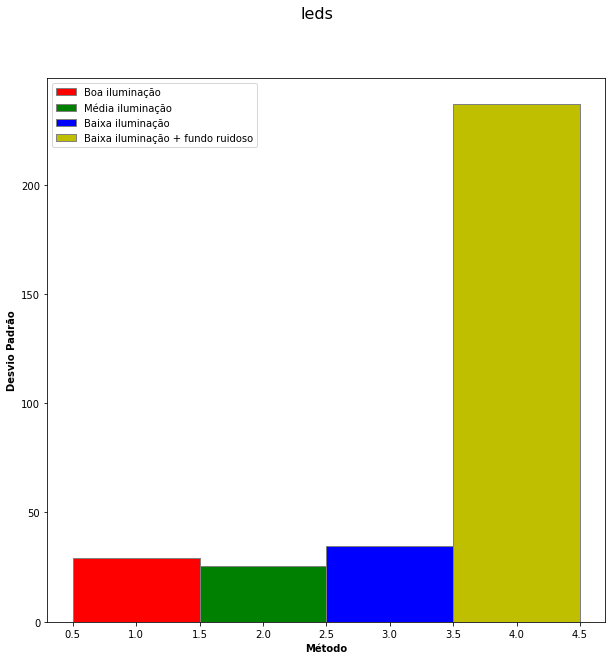

In [36]:
# Gráfico com distância média do local esperado

color = ['r', 'g', 'b', 'y']
label = ['Boa iluminação', 'Média iluminação', 'Baixa iluminação', 'Baixa iluminação + fundo ruidoso']

plt.figure(figsize=(10,10))
for i in range(4):
    plt.bar(i+1,[statistics['leds']['distanceDeviation'][i]],
                             color =color[i], width =1, edgecolor ='grey', label =label[i])

# Adding Xticks
plt.xlabel('Método', fontweight ='bold') 
plt.ylabel('Desvio Padrão', fontweight ='bold') 
plt.suptitle(m, fontsize=16)   
plt.legend()
plt.savefig('../algorithm_performance_data/graphs/'+m+'_standard_deviation.png')
plt.show()

In [37]:
import matplotlib.pyplot as plt

# Tempo médio de execução

statistics['leds']['time'].mean()

0.2763636497350839